In [64]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [65]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0



In [66]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.drop(columns=['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7'])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(77, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")




Epoch 1/200, Loss: 186.2771
Epoch 2/200, Loss: 173.3058
Epoch 3/200, Loss: 149.3918
Epoch 4/200, Loss: 113.2118
Epoch 5/200, Loss: 69.7366
Epoch 6/200, Loss: 33.6478
Epoch 7/200, Loss: 15.8101
Epoch 8/200, Loss: 8.8468
Epoch 9/200, Loss: 5.7028
Epoch 10/200, Loss: 5.0855
Epoch 11/200, Loss: 4.3092
Epoch 12/200, Loss: 2.8887
Epoch 13/200, Loss: 2.5485
Epoch 14/200, Loss: 2.1772
Epoch 15/200, Loss: 1.8825
Epoch 16/200, Loss: 1.6897
Epoch 17/200, Loss: 1.5079
Epoch 18/200, Loss: 1.4659
Epoch 19/200, Loss: 1.2621
Epoch 20/200, Loss: 1.1343
Epoch 21/200, Loss: 1.1033
Epoch 22/200, Loss: 0.9420
Epoch 23/200, Loss: 0.8617
Epoch 24/200, Loss: 0.7918
Epoch 25/200, Loss: 0.7282
Epoch 26/200, Loss: 0.6892
Epoch 27/200, Loss: 0.6613
Epoch 28/200, Loss: 0.6097
Epoch 29/200, Loss: 0.5336
Epoch 30/200, Loss: 0.5051
Epoch 31/200, Loss: 0.4824
Epoch 32/200, Loss: 0.4455
Epoch 33/200, Loss: 0.4275
Epoch 34/200, Loss: 0.4008
Epoch 35/200, Loss: 0.3880
Epoch 36/200, Loss: 0.3611
Epoch 37/200, Loss: 0.3578

In [68]:

def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

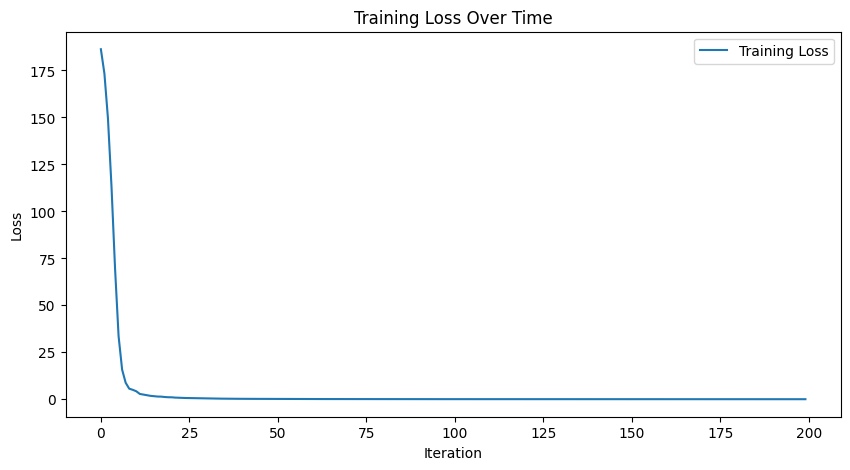

In [69]:
plot_loss()

In [70]:
def plot_compare():
    target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{target_names[i]}: Actual vs Predicted')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel(target_names[i])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

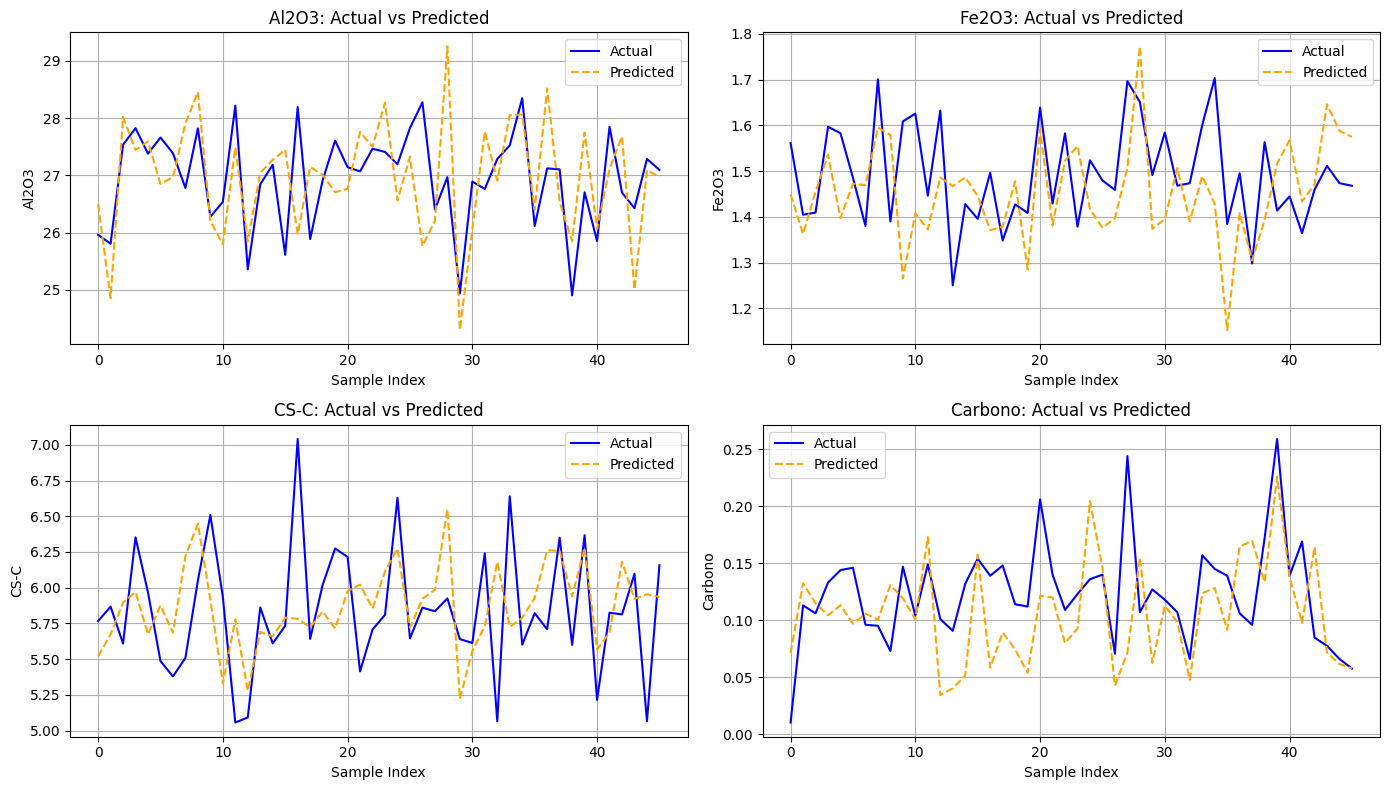

In [71]:
plot_compare()

In [72]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))

    return results_df

In [73]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.2776
 - MAE: 0.3130 
 - R2: 0.9976

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.495783  0.535095
1   1.561302   1.449286 -0.112016
2   5.767001   5.519209 -0.247792
3   0.010200   0.071218  0.061018
4  25.805275  24.853281 -0.951994
5   1.404642   1.362418 -0.042224
6   5.867491   5.673993 -0.193498
7   0.113000   0.132512  0.019512
8  27.533176  28.019283  0.486107
9   1.409339   1.455037  0.045698


## NN for the first 3 raw materials


In [74]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.iloc[:, :33]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(33, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
    


Epoch 1/200, Loss: 193.4765
Epoch 2/200, Loss: 189.2351
Epoch 3/200, Loss: 184.0720
Epoch 4/200, Loss: 176.8443
Epoch 5/200, Loss: 165.7412
Epoch 6/200, Loss: 149.5328
Epoch 7/200, Loss: 128.4105
Epoch 8/200, Loss: 102.5856
Epoch 9/200, Loss: 74.1636
Epoch 10/200, Loss: 47.0068
Epoch 11/200, Loss: 25.5759
Epoch 12/200, Loss: 12.6102
Epoch 13/200, Loss: 8.3306
Epoch 14/200, Loss: 8.2149
Epoch 15/200, Loss: 6.8200
Epoch 16/200, Loss: 5.2450
Epoch 17/200, Loss: 4.3923
Epoch 18/200, Loss: 3.8910
Epoch 19/200, Loss: 3.5336
Epoch 20/200, Loss: 3.1525
Epoch 21/200, Loss: 2.8161
Epoch 22/200, Loss: 2.5960
Epoch 23/200, Loss: 2.3862
Epoch 24/200, Loss: 2.2886
Epoch 25/200, Loss: 2.0831
Epoch 26/200, Loss: 1.9464
Epoch 27/200, Loss: 1.8436
Epoch 28/200, Loss: 1.7117
Epoch 29/200, Loss: 1.6424
Epoch 30/200, Loss: 1.5335
Epoch 31/200, Loss: 1.4502
Epoch 32/200, Loss: 1.3703
Epoch 33/200, Loss: 1.3109
Epoch 34/200, Loss: 1.2541
Epoch 35/200, Loss: 1.2100
Epoch 36/200, Loss: 1.1523
Epoch 37/200, Los

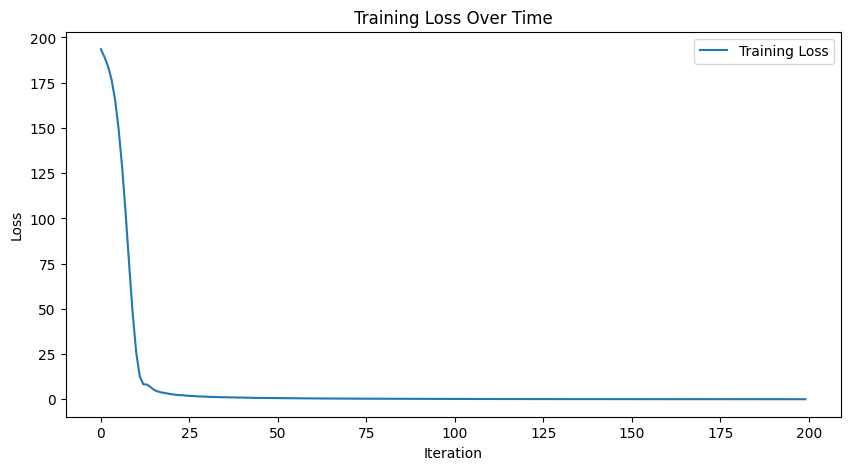

In [75]:
plot_loss()

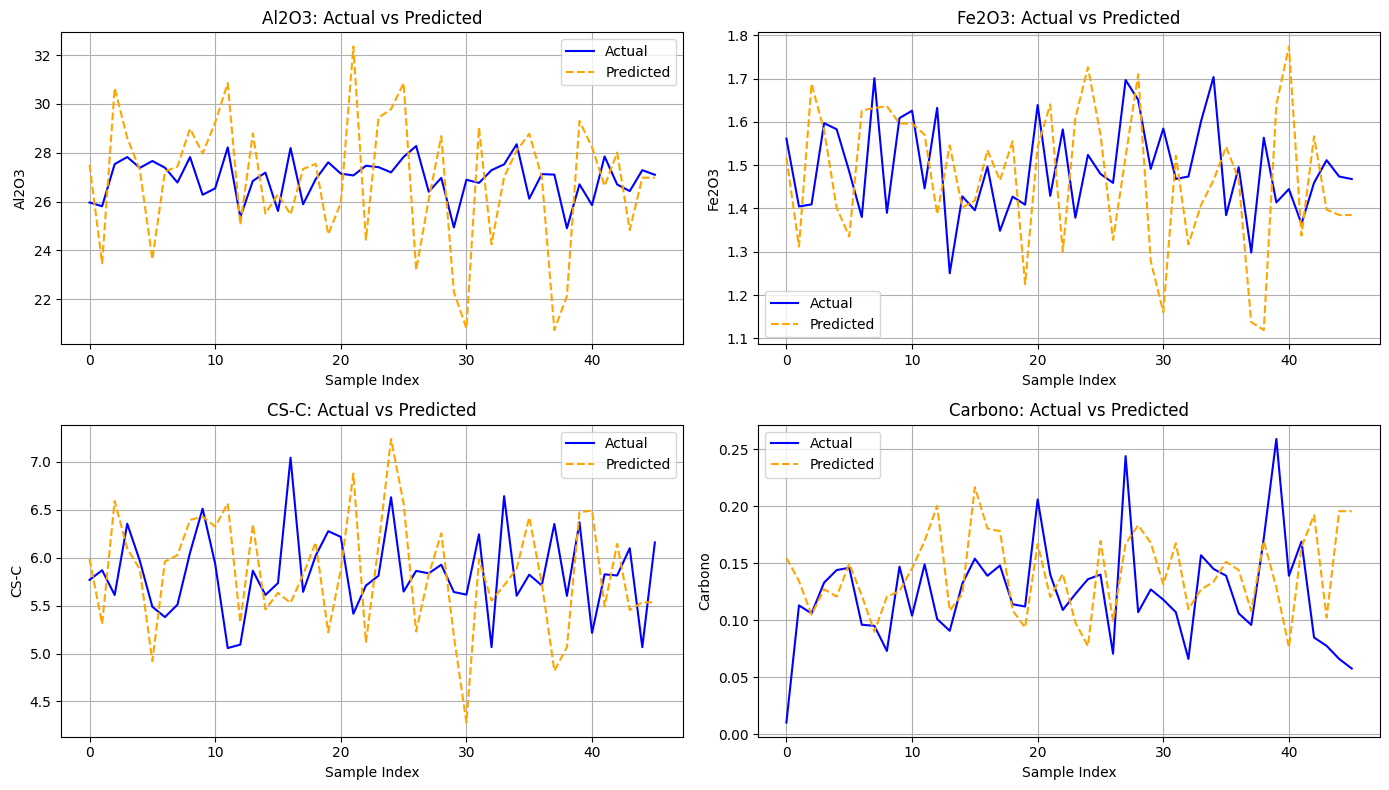

In [76]:
plot_compare()

In [77]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 1.7542
 - MAE: 0.6963 
 - R2: 0.9850

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.507755  1.547068
1   1.561302   1.517290 -0.044013
2   5.767001   5.985161  0.218160
3   0.010200   0.154684  0.144484
4  25.805275  23.465420 -2.339855
5   1.404642   1.311833 -0.092809
6   5.867491   5.308606 -0.558885
7   0.113000   0.134415  0.021415
8  27.533176  30.649216  3.116039
9   1.409339   1.687799  0.278460


## Predicting Al, Fe and Carbon using those features and their use %

In [78]:
y = data[['Al2O3.7', 'Fe2O3.7', 'Carbono.7']]
X = data.filter(regex="Al2O3|Fe2O3|Carbono|%")
X = X.drop(columns=['Al2O3.7', 'Fe2O3.7', 'Carbono.7'])


In [79]:
X.shape, y.shape

((230, 28), (230, 3))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 3), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 3), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 3)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
    

Epoch 1/200, Loss: 243.6770
Epoch 2/200, Loss: 238.1323
Epoch 3/200, Loss: 229.1442
Epoch 4/200, Loss: 216.5116
Epoch 5/200, Loss: 195.5751
Epoch 6/200, Loss: 165.6832
Epoch 7/200, Loss: 128.3677
Epoch 8/200, Loss: 86.2054
Epoch 9/200, Loss: 48.3008
Epoch 10/200, Loss: 23.4520
Epoch 11/200, Loss: 14.1156
Epoch 12/200, Loss: 10.8213
Epoch 13/200, Loss: 9.0478
Epoch 14/200, Loss: 6.6096
Epoch 15/200, Loss: 5.5940
Epoch 16/200, Loss: 4.6491
Epoch 17/200, Loss: 3.8885
Epoch 18/200, Loss: 3.3919
Epoch 19/200, Loss: 3.0956
Epoch 20/200, Loss: 2.5810
Epoch 21/200, Loss: 2.4204
Epoch 22/200, Loss: 2.0523
Epoch 23/200, Loss: 1.8601
Epoch 24/200, Loss: 1.7655
Epoch 25/200, Loss: 1.6476
Epoch 26/200, Loss: 1.4300
Epoch 27/200, Loss: 1.3223
Epoch 28/200, Loss: 1.3013
Epoch 29/200, Loss: 1.2080
Epoch 30/200, Loss: 1.0583
Epoch 31/200, Loss: 0.9822
Epoch 32/200, Loss: 0.9665
Epoch 33/200, Loss: 0.9051
Epoch 34/200, Loss: 0.8290
Epoch 35/200, Loss: 0.7527
Epoch 36/200, Loss: 0.7066
Epoch 37/200, Loss

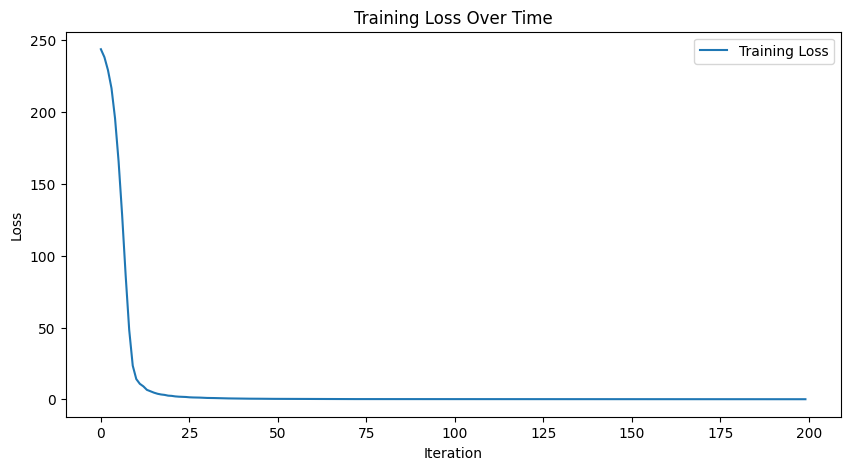

In [81]:
plot_loss()

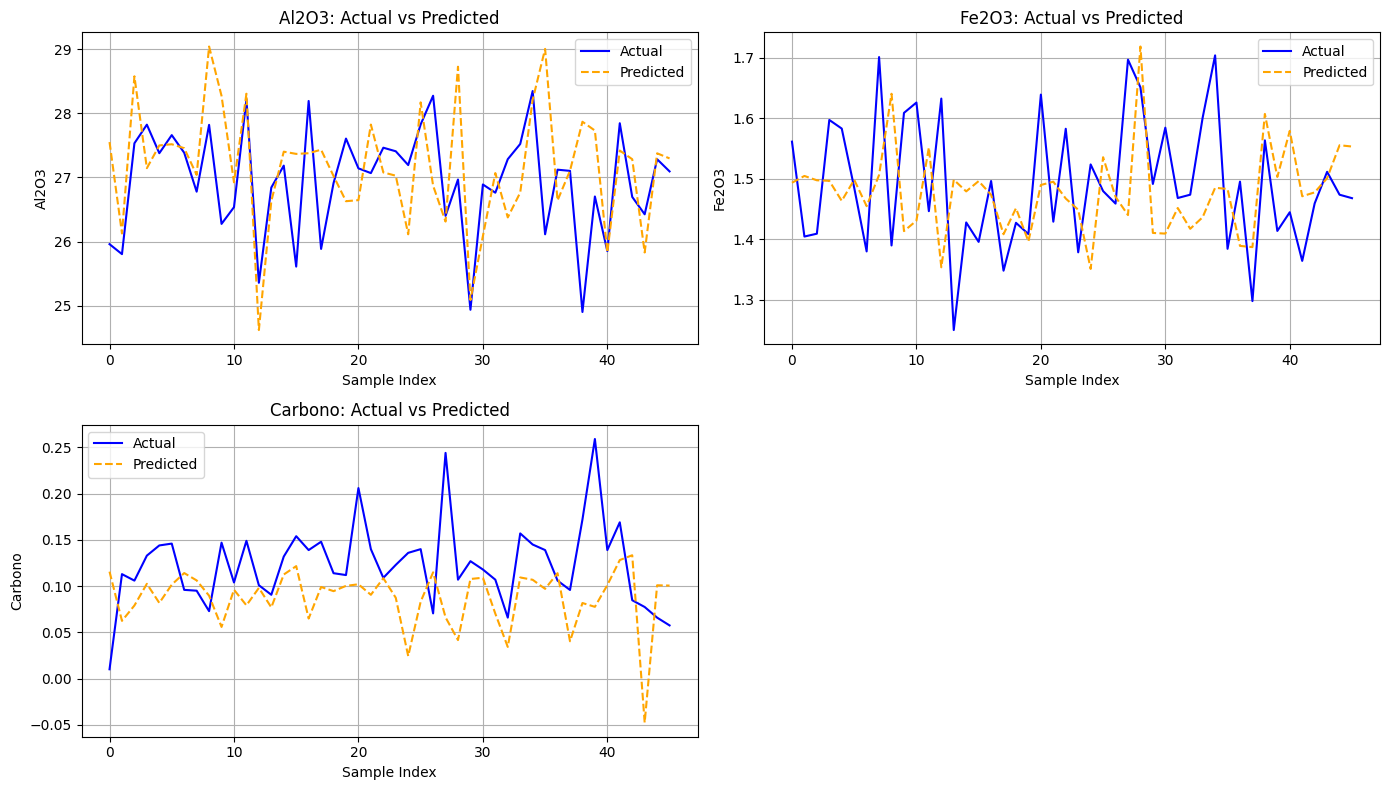

In [91]:
target_names = ['Al2O3', 'Fe2O3','Carbono']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axs.ravel()):
    if i >= len(target_names):
        break
    actual = y_test_tensor[:, i].numpy()
    pred = predictions[:, i].numpy()
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', linestyle='--', color='orange')
    ax.set_title(f'{target_names[i]}: Actual vs Predicted')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(target_names[i])
    ax.grid(True)
    ax.legend()


for i in range(len(target_names), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

In [87]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.3448
 - MAE: 0.2932 
 - R2: 0.9977

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.551796  1.591108
1   1.561302   1.493445 -0.067857
2   0.010200   0.115675  0.105475
3  25.805275  26.127237  0.321962
4   1.404642   1.504671  0.100029
5   0.113000   0.062506 -0.050494
6  27.533176  28.576986  1.043810
7   1.409339   1.497514  0.088175
8   0.106000   0.079126 -0.026874
9  27.822983  27.145273 -0.677710
